# 目的
遺伝子学的分類に基づいた、再発の2値分類を実施する。  

In [1]:
# 基本的なライブラリ
import os
from tqdm import tqdm

import numpy as np
import pandas as pd

pd.set_option("display.max_columns", 50)

import matplotlib.pyplot as plt

%matplotlib inline

# パイプライン（imblearn）
from imblearn.pipeline import Pipeline
from imblearn import FunctionSampler

# モデル
from sksurv.ensemble import (
    ComponentwiseGradientBoostingSurvivalAnalysis,
    GradientBoostingSurvivalAnalysis,
    RandomSurvivalForest,
    ExtraSurvivalTrees,
)
from sksurv.svm import FastKernelSurvivalSVM
from sksurv.linear_model import IPCRidge


# 評価指標
from sksurv.metrics import cumulative_dynamic_auc, concordance_index_ipcw

import config
import functions

SEED = config.SEED
TARGET_NAME = ["RFS_STATUS", "RFS_MONTHS"]
functions.fix_seed(SEED)


df_recurrenced = pd.read_pickle(
    config.INTERIM_PREPROCESSED_RECURRENCE_DIR + "/df_recurrenced4numeric.pkl"
)

/home/breast-cancer-analytics/notebooks/functions.py:185: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  y_train: pd.Series(),
/home/breast-cancer-analytics/notebooks/functions.py:187: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  y_val: pd.Series(),


# データ全体での予測モデル検証

## ベースモデルの学習結果

各特徴量選択されたdfを用いて基本的な2値分類モデルを学習する

In [2]:
def save_model_pipeline(
    pipeline: callable,
    val_step: str,
    save_file_path: str = ".",
):
    # fit後pipelineの保存
    pipeline_path = "{0}/{1}".format(save_file_path, val_step)
    functions.make_dir(pipeline_path)
    functions.pickle_dump(pipeline, "{0}/model_pipeline.pkl".format(pipeline_path))

In [3]:
def exists_pipeline(path: str) -> bool:
    return os.path.exists(path)

In [4]:
def validate_model(
    model_order: dict = {"original_data": []},
    val_step="val_set",
    input_data_path: str = None,
    output_data_path: str = None,
    is_fitted: bool = False,
):
    try:
        _X_train = pd.read_pickle(
            "{0}/{1}/train/X.pkl".format(input_data_path, val_step)
        )
        _y_train = pd.read_pickle(
            "{0}/{1}/train/y.pkl".format(input_data_path, val_step)
        ).to_records(index=False)
        _X_test = pd.read_pickle("{0}/{1}/test/X.pkl".format(input_data_path, val_step))
        _y_test = pd.read_pickle(
            "{0}/{1}/test/y.pkl".format(input_data_path, val_step)
        ).to_records(index=False)
    except:
        print("preprocess pkl file dose not exist")
        return

    pipeline_path = "{0}/{1}".format(output_data_path, val_step)
    if exists_pipeline(pipeline_path) and is_fitted:
        # 学習済みパイプラインの使用
        _model_pipeline = functions.pickle_load(
            "{0}/model_pipeline.pkl".format(pipeline_path)
        )
    else:
        # パイプラインの学習の実施
        _model_pipeline = Pipeline(steps=model_order)
        _model_pipeline.fit(_X_train, _y_train)

    _y_train_pred = _model_pipeline.predict(_X_train)
    _y_test_pred = _model_pipeline.predict(_X_test)

    _estimator = _model_pipeline[-1]

    # c-indexスコアの表示
    _train_score = _estimator.score(_X_train, _y_train)
    _test_score = _estimator.score(_X_test, _y_test)
    score_cindex = pd.DataFrame(
        [[_train_score, _test_score]],
        columns=["train score", "test score"],
        index=["c-index"],
    )
    display(score_cindex.round(3))

    # テストデータ患者のハザード率のプロット
    """
    chf_funcs = _estimator.predict_cumulative_hazard_function(_X_test)
    for fn in chf_funcs:
        plt.step(fn.x, fn(fn.x), where="post")

    plt.ylim(0, 1)
    plt.axvline(x=60)
    plt.axvline(x=120)
    plt.axvline(x=180)
    plt.show()
    """

    # 累積AUCの表示
    va_times = np.arange(
        pd.DataFrame(_y_test).RFS_MONTHS.min(),
        pd.DataFrame(_y_test).RFS_MONTHS.max(),
        1,
    )
    cph_auc, cph_mean_auc = cumulative_dynamic_auc(
        _y_train, _y_test, _y_test_pred, va_times
    )

    print(cph_mean_auc)
    plt.plot(va_times, cph_auc, label=_estimator.__class__.__name__)
    # plt.axhline(cph_mean_auc, linestyle="--")
    # 5,10,15年後ライン
    plt.axvline(5 * 12)
    plt.axvline(10 * 12)
    plt.axvline(15 * 12)
    plt.xlabel("days from surgery")
    plt.ylabel("time-dependent AUC")
    plt.xlim(0, 250)
    plt.ylim(0, 1)
    plt.grid(True)
    plt.legend()

    if output_data_path:
        save_model_pipeline(
            pipeline=_model_pipeline, val_step=val_step, save_file_path=output_data_path
        )
    return

In [5]:
# 実施したい学習の定義
model_order_dicts = [
    {
        "model_name": ComponentwiseGradientBoostingSurvivalAnalysis().__class__.__name__,
        "preprocess_name": "preprocess4numeric_pca85",
        "model_order": [
            (
                ComponentwiseGradientBoostingSurvivalAnalysis().__class__.__name__,
                ComponentwiseGradientBoostingSurvivalAnalysis(
                    random_state=config.SEED,
                ),
            ),
        ],
    },
    {
        "model_name": GradientBoostingSurvivalAnalysis().__class__.__name__,
        "preprocess_name": "preprocess4numeric_pca85",
        "model_order": [
            (
                GradientBoostingSurvivalAnalysis().__class__.__name__,
                GradientBoostingSurvivalAnalysis(
                    random_state=config.SEED,
                ),
            ),
        ],
    },
    {
        "model_name": RandomSurvivalForest().__class__.__name__,
        "preprocess_name": "preprocess4numeric_pca85",
        "model_order": [
            (
                RandomSurvivalForest().__class__.__name__,
                RandomSurvivalForest(
                    n_estimators=1000,
                    min_samples_split=10,
                    min_samples_leaf=15,
                    n_jobs=-1,
                    random_state=config.SEED,
                ),
            ),
        ],
    },
    {
        "model_name": ExtraSurvivalTrees().__class__.__name__,
        "preprocess_name": "preprocess4numeric_pca85",
        "model_order": [
            (
                ExtraSurvivalTrees().__class__.__name__,
                ExtraSurvivalTrees(
                    random_state=config.SEED,
                ),
            ),
        ],
    },
]

####################################################################################################
subgroup_column:  CLAUDIN_SUBTYPE
subgroup:  claudin-low
....................................................................................................
model_order_dict name:  ComponentwiseGradientBoostingSurvivalAnalysis


,train score,test score
c-index,0.785,0.443


0.4880073471185384
....................................................................................................
model_order_dict name:  GradientBoostingSurvivalAnalysis


,train score,test score
c-index,0.987,0.614


0.644404494665149
....................................................................................................
model_order_dict name:  RandomSurvivalForest


,train score,test score
c-index,0.945,0.557


0.532544142312191
....................................................................................................
model_order_dict name:  ExtraSurvivalTrees


,train score,test score
c-index,0.972,0.557


0.5729914255861458


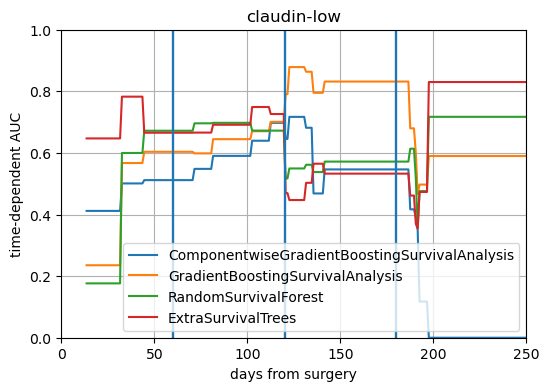

subgroup:  LumA
....................................................................................................
model_order_dict name:  ComponentwiseGradientBoostingSurvivalAnalysis


,train score,test score
c-index,0.695,0.634


0.6447264932409579
....................................................................................................
model_order_dict name:  GradientBoostingSurvivalAnalysis


,train score,test score
c-index,0.93,0.578


0.6059170424245884
....................................................................................................
model_order_dict name:  RandomSurvivalForest


,train score,test score
c-index,0.945,0.529


0.5273851492201743
....................................................................................................
model_order_dict name:  ExtraSurvivalTrees


,train score,test score
c-index,0.972,0.415


0.40271565806340937


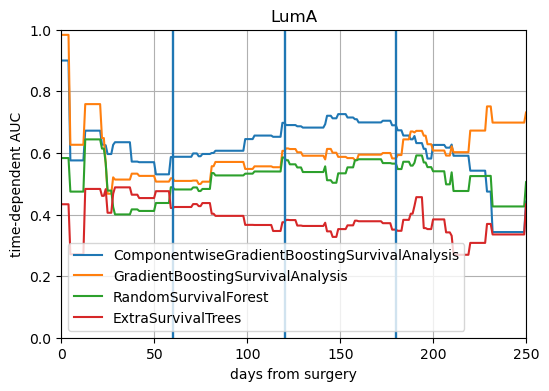

subgroup:  LumB
....................................................................................................
model_order_dict name:  ComponentwiseGradientBoostingSurvivalAnalysis


,train score,test score
c-index,0.702,0.597


/root/miniconda3/envs/breast-cancer-analytics/lib/python3.8/site-packages/sksurv/metrics.py:493: RuntimeWarning: invalid value encountered in divide
  true_pos = cumsum_tp / cumsum_tp[-1]


nan
....................................................................................................
model_order_dict name:  GradientBoostingSurvivalAnalysis


,train score,test score
c-index,0.931,0.627


/root/miniconda3/envs/breast-cancer-analytics/lib/python3.8/site-packages/sksurv/metrics.py:493: RuntimeWarning: invalid value encountered in divide
  true_pos = cumsum_tp / cumsum_tp[-1]


nan
....................................................................................................
model_order_dict name:  RandomSurvivalForest


,train score,test score
c-index,0.927,0.61


/root/miniconda3/envs/breast-cancer-analytics/lib/python3.8/site-packages/sksurv/metrics.py:493: RuntimeWarning: invalid value encountered in divide
  true_pos = cumsum_tp / cumsum_tp[-1]


nan
....................................................................................................
model_order_dict name:  ExtraSurvivalTrees


,train score,test score
c-index,0.964,0.612


/root/miniconda3/envs/breast-cancer-analytics/lib/python3.8/site-packages/sksurv/metrics.py:493: RuntimeWarning: invalid value encountered in divide
  true_pos = cumsum_tp / cumsum_tp[-1]


nan


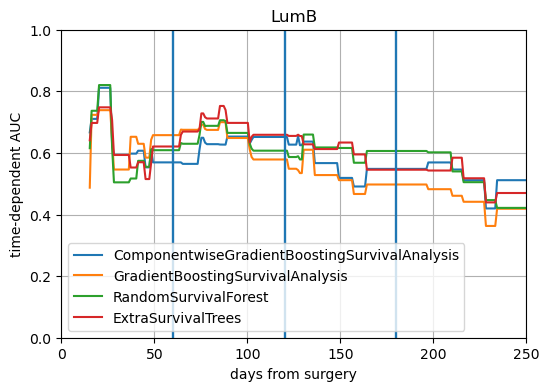

subgroup:  Her2
....................................................................................................
model_order_dict name:  ComponentwiseGradientBoostingSurvivalAnalysis


,train score,test score
c-index,0.746,0.446


0.464459607237528
....................................................................................................
model_order_dict name:  GradientBoostingSurvivalAnalysis


,train score,test score
c-index,0.961,0.489


0.4792257847398787
....................................................................................................
model_order_dict name:  RandomSurvivalForest


,train score,test score
c-index,0.913,0.547


0.4687303980940783
....................................................................................................
model_order_dict name:  ExtraSurvivalTrees


,train score,test score
c-index,0.961,0.496


0.4687291218722041


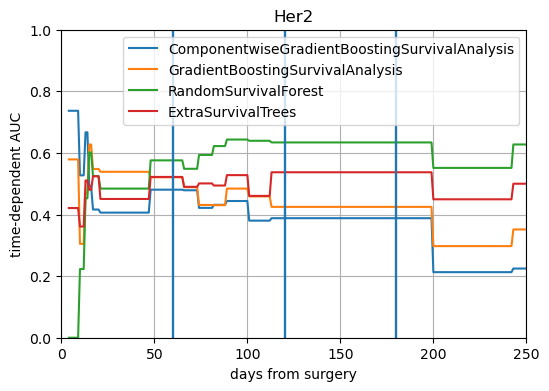

subgroup:  Normal
....................................................................................................
model_order_dict name:  ComponentwiseGradientBoostingSurvivalAnalysis


,train score,test score
c-index,0.774,0.596


0.6123931586971811
....................................................................................................
model_order_dict name:  GradientBoostingSurvivalAnalysis


,train score,test score
c-index,0.992,0.553


0.6611547151771074
....................................................................................................
model_order_dict name:  RandomSurvivalForest


,train score,test score
c-index,0.915,0.617


0.6725622501356301
....................................................................................................
model_order_dict name:  ExtraSurvivalTrees


,train score,test score
c-index,0.957,0.404


0.42630103462413677


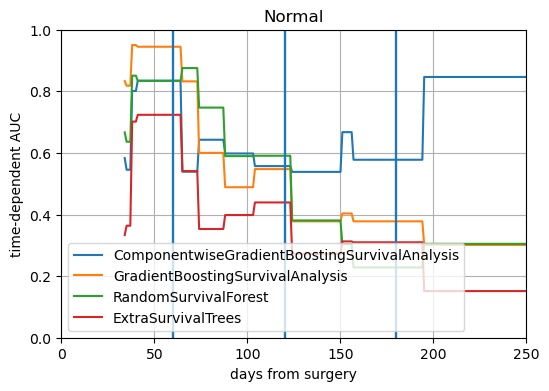

subgroup:  Basal
....................................................................................................
model_order_dict name:  ComponentwiseGradientBoostingSurvivalAnalysis


,train score,test score
c-index,0.718,0.533


0.47212262341602007
....................................................................................................
model_order_dict name:  GradientBoostingSurvivalAnalysis


,train score,test score
c-index,0.978,0.419


0.34974404650261515
....................................................................................................
model_order_dict name:  RandomSurvivalForest


,train score,test score
c-index,0.929,0.21


0.1266257928841215
....................................................................................................
model_order_dict name:  ExtraSurvivalTrees


,train score,test score
c-index,0.967,0.467


0.42195216743583214


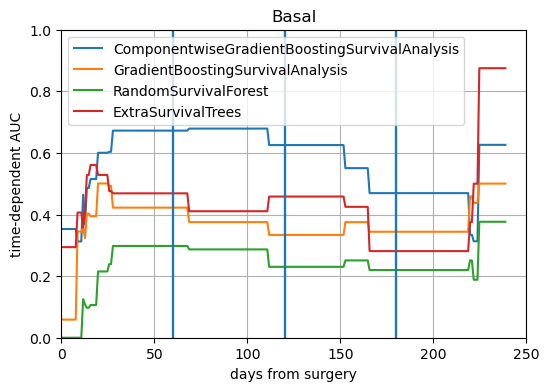

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


subgroup:  NC
....................................................................................................
model_order_dict name:  ComponentwiseGradientBoostingSurvivalAnalysis
preprocess pkl file dose not exist
....................................................................................................
model_order_dict name:  GradientBoostingSurvivalAnalysis
preprocess pkl file dose not exist
....................................................................................................
model_order_dict name:  RandomSurvivalForest
preprocess pkl file dose not exist
....................................................................................................
model_order_dict name:  ExtraSurvivalTrees
preprocess pkl file dose not exist


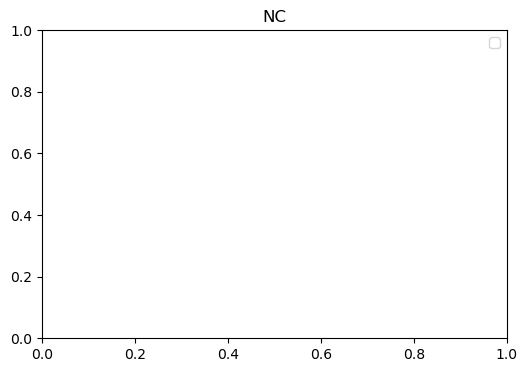

In [6]:
# 層別化する特徴量
subgroup_columns = [
    "CLAUDIN_SUBTYPE",
    # "THREEGENE",
]
# 遺伝子発現量以外の特徴量を削除
drop_columns = [
    "CLAUDIN_SUBTYPE",
    "THREEGENE",
]

val_steps = ["val_set"]
for subgroup_column in subgroup_columns:  # 各サブグループへの適用
    print("##########" * 10)
    print("subgroup_column: ", subgroup_column)

    """
    plt.figure(
        figsize=(
            len(df_recurrenced[subgroup_column].unique()) * 6,
            # len(model_order_dicts) * 4,
            4,
        )
    )
    """

    for col, subgroup in enumerate(
        df_recurrenced[subgroup_column].unique()
    ):  # サブグループの要素毎への適用
        print("==========" * 10)
        print("subgroup: ", subgroup)

        plt.figure(figsize=(6, 4))
        for row, model_order_dict in enumerate(model_order_dicts):
            print(".........." * 10)
            print("model_order_dict name: ", model_order_dict["model_name"])
            input_data_path = "./{0}/{1}/{2}/{3}".format(
                config.INTERIM_PREPROCESSED_RECURRENCE_DIR,
                subgroup_column,
                subgroup,
                model_order_dict["preprocess_name"],
            )
            output_data_path = "./{0}/{1}/{2}/{3}/{4}".format(
                config.INTERIM_MODELS_RECURRENCE_DIR,
                subgroup_column,
                subgroup,
                model_order_dict["preprocess_name"],
                model_order_dict["model_name"],
            )
            # plt.subplot(1, len(df_recurrenced[subgroup_column].unique()), col + 1)

            for val_step in val_steps:
                validate_model(
                    model_order=model_order_dict["model_order"],
                    val_step=val_step,
                    input_data_path=input_data_path,
                    output_data_path=output_data_path,
                    is_fitted=True,
                )
            plt.title(subgroup)
        output_fig_path = "./{0}/{1}/{2}/{3}".format(
            config.FIGURES_MODELS_RECURRENCE_DIR,
            subgroup_column,
            subgroup,
            model_order_dict["preprocess_name"],
        )
        functions.make_dir(output_fig_path)
        plt.legend()
        plt.savefig("{0}/time-dependent AUC.png".format(output_fig_path))
        plt.show()